In [2]:
import xarray as xr
import numpy as np
from google.cloud import storage
import gcsfs
import fsspec
from kerchunk.hdf import SingleHdf5ToZarr 
from kerchunk.combine import MultiZarrToZarr
from pathlib import Path
import ujson
from dask.distributed import Client, LocalCluster
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LongitudeFormatter, LatitudeFormatter
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import scores
import pandas as pd
import seaborn as sns
import ecmwflibs
import eccodes
import cfgrib
import herbie.accessors


ModuleNotFoundError: No module named 'cartopy.crs'

This notebook is designed as an end-to-end implementation of ExtremeWeatherBench for the Pacific Northwest Heatwave which occurred between 2021 June 26, 00z and 2021 June 30, 00z

# Define constants

In [101]:
bounding_box = [-125, -116, 42, 60] # W, E, S, N
temperature_ehe_percentile = 0.85 # Defined as the baseline for a daily min, max, mean, or apparent temperture which is considered an extreme heat event
# 2020 onwards purposefully avoided as recent years were used to train AI models
climatology_min = 1990
climatology_max = 2019

#point obs locations, seatac, bellingham, vancouver, lytton
ksea_coords = (47.44469, -122.31437)
kbli_coords = (48.79269, -122.53753)
cyvr_coords = (49.18303, -123.16823)
cwly_coords = (50.22448, -121.58180)

point_df = pd.DataFrame(
    {
    "longitude": [n[1] for n in [ksea_coords, kbli_coords, cyvr_coords, cwly_coords]],
    "latitude": [n[0] for n in [ksea_coords, kbli_coords, cyvr_coords, cwly_coords]]
    }
)

# Define Functions

In [89]:
def convert_longitude_to_360(longitude):
    return longitude % 360

def generate_json_from_grap_nc(u,fs, fs_out):
    with fs.open(u, **so) as infile:
        h5chunks = SingleHdf5ToZarr(infile, u, inline_threshold=300)

        file_split = u.split('/') # seperate file path to create a unique name for each json 
        model = file_split[1].split('_')[0]
        date_string = file_split[-1].split('_')[3]
        outf = f'{json_dir}{model}_{date_string}_.json'
        print(outf)
        with fs_out.open(outf, 'wb') as f:
            f.write(ujson.dumps(h5chunks.translate()).encode());

# seasonal aggregation functions for max, min, and mean
def seasonal_subset_max(df):
    df = df.where(df.index.month.isin([6,7,8]))
    return df.max()

def seasonal_subset_min(df):
    df = df.where(df.index.month.isin([6,7,8]))
    return df.min()

def seasonal_subset_mean(df):
    df = df.where(df.index.month.isin([6,7,8]))
    return df.mean()

# Initialize Dask Cluster

In [ ]:
cluster = LocalCluster(
    n_workers=8,
    threads_per_worker=4,
    memory_limit='3GiB',
)
client = Client(cluster)

x:\anaconda3\envs\brightband\Lib\site-packages\distributed\node.py:187: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 54969 instead
  warnings.warn(


KeyboardInterrupt: 

In [ ]:
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 8
Total threads: 32,Total memory: 24.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:52312,Workers: 8
Dashboard: http://127.0.0.1:8787/status,Total threads: 32
Started: Just now,Total memory: 24.00 GiB
Comm: tcp://127.0.0.1:52364,Total threads: 4
Dashboard: http://127.0.0.1:52367/status,Memory: 3.00 GiB
Nanny: tcp://127.0.0.1:52315,


# Begin Data Pull

In [106]:
gcs_client = storage.Client()
bucket = gcs_client.get_bucket('bb-cira-oar-mlwp-data')

In [ ]:
fs_read = fsspec.filesystem('gcs', anon=False, skip_instance_cache=True)
fs_local = fsspec.filesystem('')  
json_dir = 'assets/json/'
so = dict(mode='rb', anon=True, default_fill_cache=False, default_cache_type='first')

def convert_longitude_to_360(longitude):
    return longitude % 360

def generate_json_from_grap_nc(u,fs, fs_out):
    with fs.open(u, **so) as infile:
        h5chunks = SingleHdf5ToZarr(infile, u, inline_threshold=300)

        file_split = u.split('/') # seperate file path to create a unique name for each json 
        model = file_split[1].split('_')[0]
        date_string = file_split[-1].split('_')[3]
        outf = f'{json_dir}{model}_{date_string}_.json'
        print(outf)
        with fs_out.open(outf, 'wb') as f:
            f.write(ujson.dumps(h5chunks.translate()).encode());



In [ ]:
file_list = fs_read.glob('gs://bb-cira-oar-mlwp-data/PANG_v100/2021/**/*.nc')

In [ ]:
for file in file_list:
    generate_json_from_grap_nc(file,fs_read, fs_local)

assets/json/PANG_2021062100_.json
assets/json/PANG_2021062112_.json
assets/json/PANG_2021062200_.json
assets/json/PANG_2021062212_.json
assets/json/PANG_2021062300_.json
assets/json/PANG_2021062312_.json
assets/json/PANG_2021062400_.json
assets/json/PANG_2021062412_.json
assets/json/PANG_2021062500_.json
assets/json/PANG_2021062512_.json
assets/json/PANG_2021062600_.json
assets/json/PANG_2021062612_.json
assets/json/PANG_2021062700_.json
assets/json/PANG_2021062712_.json
assets/json/PANG_2021062800_.json
assets/json/PANG_2021062812_.json
assets/json/PANG_2021062900_.json
assets/json/PANG_2021062912_.json
assets/json/PANG_2021063000_.json
assets/json/PANG_2021063012_.json
assets/json/PANG_2021070100_.json
assets/json/PANG_2021070112_.json
assets/json/PANG_2021070200_.json
assets/json/PANG_2021070212_.json
assets/json/PANG_2021070300_.json
assets/json/PANG_2021070312_.json


In [ ]:
json_list = fs_local.glob(str(json_dir)+'PANG*_.json')

# Load in all point source obs, compute 85th percentiles

In [93]:
point_obs_dict = {}
point_obs_dict['KSEA'] = {}
point_obs_dict['KBLI'] = {}
point_obs_dict['CYVR'] = {}
point_obs_dict['CWLY'] = {}

for station in point_obs_dict.items():
    station[1]['data'] = pd.read_csv(f'assets/data/{station[0]}.csv').dropna()
    station[1]['data']['valid'] = pd.to_datetime(station[1]['data']['valid'])
    station[1]['data']['tmpc'] = station[1]['data']['tmpc'].astype(float)
    station[1]['data'] = station[1]['data'].set_index('valid')
    station[1]['data'] = station[1]['data'].resample('h').mean(numeric_only=True)
    subset_summer_df = station[1]['data']['tmpc'][station[1]['data']['tmpc'].index.month.isin([6,7,8])]
    station[1]['max_temp_85th_percentile'] = np.nanpercentile(subset_summer_df.resample('D').max(),85)
    station[1]['min_temp_85th_percentile'] = np.nanpercentile(subset_summer_df.resample('D').min(),85)
    station[1]['mean_temp_85th_percentile'] = np.nanpercentile(subset_summer_df.resample('D').mean(),85)

In [100]:
point_obs_dict['CWLY']

{'data':                      tmpc
 valid                    
 1989-01-01 00:00:00  -7.6
 1989-01-01 01:00:00  -9.0
 1989-01-01 02:00:00  -9.0
 1989-01-01 03:00:00  -9.0
 1989-01-01 04:00:00  -9.0
 ...                   ...
 2019-12-30 19:00:00   2.0
 2019-12-30 20:00:00   2.0
 2019-12-30 21:00:00   4.0
 2019-12-30 22:00:00   4.0
 2019-12-30 23:00:00   5.0
 
 [271704 rows x 1 columns],
 'max_temp_85th_percentile': np.float64(35.0),
 'min_temp_85th_percentile': np.float64(18.0),
 'mean_temp_85th_percentile': np.float64(25.252333333333333)}

# Load in KSEA Temp Obs and Compare

In [103]:
json_list = fs_local.glob(str(json_dir)+'PANG*_.json')

In [104]:
asos_pang_df = pd.DataFrame()
for json_file in json_list:
    fs_ = fsspec.filesystem("reference", fo=json_file, ref_storage_args={'skip_instance_cache':True},
                       remote_protocol='gcs', remote_options={'anon':True})
    m = fs_.get_mapper("")
    ds = xr.open_dataset(m, engine="zarr", backend_kwargs={'consolidated':False}, chunks={})
    df = ds['t2'].herbie.nearest_points(points=point_df).to_dataframe()
    model_run_time = np.datetime64(pd.to_datetime(ds.attrs['initialization_time']))
    fhours = ds['time'] - model_run_time
    fhours = fhours.values/ np.timedelta64(1, 'h')
    df['fhour'] = fhours
    df['init_time'] = model_run_time
    asos_pang_df = pd.concat([asos_pang_df,df])
asos_pang_df.to_csv('assets/data/asos_pangu.csv')

_request out of retries on exception: Reauthentication is needed. Please run `gcloud auth application-default login` to reauthenticate.
Traceback (most recent call last):
  File "x:\anaconda3\envs\brightband\Lib\site-packages\gcsfs\retry.py", line 130, in retry_request
    return await func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "x:\anaconda3\envs\brightband\Lib\site-packages\gcsfs\core.py", line 431, in _request
    headers=self._get_headers(headers),
            ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "x:\anaconda3\envs\brightband\Lib\site-packages\gcsfs\core.py", line 408, in _get_headers
    self.credentials.apply(out)
  File "x:\anaconda3\envs\brightband\Lib\site-packages\gcsfs\credentials.py", line 188, in apply
    self.maybe_refresh()
  File "x:\anaconda3\envs\brightband\Lib\site-packages\gcsfs\credentials.py", line 182, in maybe_refresh
    self.credentials.refresh(req)
  File "x:\anaconda3\envs\brightband\Lib\site-packages\google\oauth2\credentials.py", line

ReferenceNotReachable: Reference "latitude/0" failed to fetch target ['bb-cira-oar-mlwp-data/PANG_v100/2021/0621/PANG_v100_GFS_2021062100_f000_f240_06.nc', 9984, 2884]

In [ ]:
ds

<xarray.Dataset> Size: 12GB
Dimensions:    (latitude: 721, level: 13, longitude: 1440, time: 41)
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * level      (level) int32 52B 1000 925 850 700 600 500 ... 250 200 150 100 50
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 328B 2021-07-03T12:00:00 ... 2021-07-13T...
Data variables:
    msl        (time, latitude, longitude) float32 170MB dask.array<chunksize=(14, 241, 480), meta=np.ndarray>
    q          (time, level, latitude, longitude) float32 2GB dask.array<chunksize=(11, 3, 181, 360), meta=np.ndarray>
    t          (time, level, latitude, longitude) float32 2GB dask.array<chunksize=(11, 3, 181, 360), meta=np.ndarray>
    t2         (time, latitude, longitude) float32 170MB dask.array<chunksize=(14, 241, 480), meta=np.ndarray>
    u          (time, level, latitude, longitude) float32 2GB dask.array<chunksize=(11, 3, 181, 360), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 170MB dask.array<chunksize=(14, 241, 480), meta=np.ndarray>
    v          (time, level, latitude, longitude) float32 2GB dask.array<chunksize=(11, 3, 181, 360), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 170MB dask.array<chunksize=(14, 241, 480), meta=np.ndarray>
    z          (time, level, latitude, longitude) float32 2GB dask.array<chunksize=(11, 3, 181, 360), meta=np.ndarray>
Attributes:
    Conventions:           CF-1.8
    creation_time:         2023-11-21T22:39:39
    first_forecast_hour:   6
    forecast_hour_step:    6
    initialization_model:  GFS
    initialization_time:   2021-07-03T12:00:00
    last_forecast_hour:    240
    model_name:            Pangu-Weather
    model_version:         v1
    version:               1_2023-10-14

In [ ]:
ksea_pang_df

,latitude,longitude,t2,fhour,init_time
time,,,,,
2021-06-21 00:00:00,47.5,237.75,300.276581,0.0,2021-06-21 00:00:00
2021-06-21 06:00:00,47.5,237.75,293.155029,6.0,2021-06-21 00:00:00
2021-06-21 12:00:00,47.5,237.75,289.551270,12.0,2021-06-21 00:00:00
2021-06-21 18:00:00,47.5,237.75,297.515198,18.0,2021-06-21 00:00:00
2021-06-22 00:00:00,47.5,237.75,302.009308,24.0,2021-06-21 00:00:00
...,...,...,...,...,...
2021-07-12 12:00:00,47.5,237.75,291.291534,216.0,2021-07-03 12:00:00
2021-07-12 18:00:00,47.5,237.75,300.015137,222.0,2021-07-03 12:00:00
2021-07-13 00:00:00,47.5,237.75,303.311035,228.0,2021-07-03 12:00:00


In [ ]:
# ksea_grap_df.to_csv('assets/data/ksea_graphcast.csv')

In [44]:
merged_pangu_ksea_asos_df = pd.merge(ksea_pang_df.reset_index(), ksea_df_time_shifted.reset_index(), left_on='time',right_on='valid', how='inner')
heatwave_time_mask = (merged_pangu_ksea_asos_df['time']>='2021-06-26') & (merged_pangu_ksea_asos_df['time']<='2021-06-30')
merged_pangu_ksea_asos_df['pangu_t2c'] = merged_pangu_ksea_asos_df['t2'] - 273.15


In [ ]:
min_temps = merged_pangu_ksea_asos_df.set_index('time').resample('D').min()
max_temps = merged_pangu_ksea_asos_df.set_index('time').resample('D').max()
mean_temps = merged_pangu_ksea_asos_df.set_index('time').resample('D').mean()

merged_pangu_ksea_asos_df['error'] = merged_pangu_ksea_asos_df['pangu_t2c'] - merged_pangu_ksea_asos_df['tmpc']
# merged_pangu_ksea_asos_df['min_temp_error'] = merged_pangu_ksea_asos_df['pangu_t2c'] - merged_pangu_ksea_asos_df['tmpc']



<Axes: xlabel='fhour', ylabel='error'>

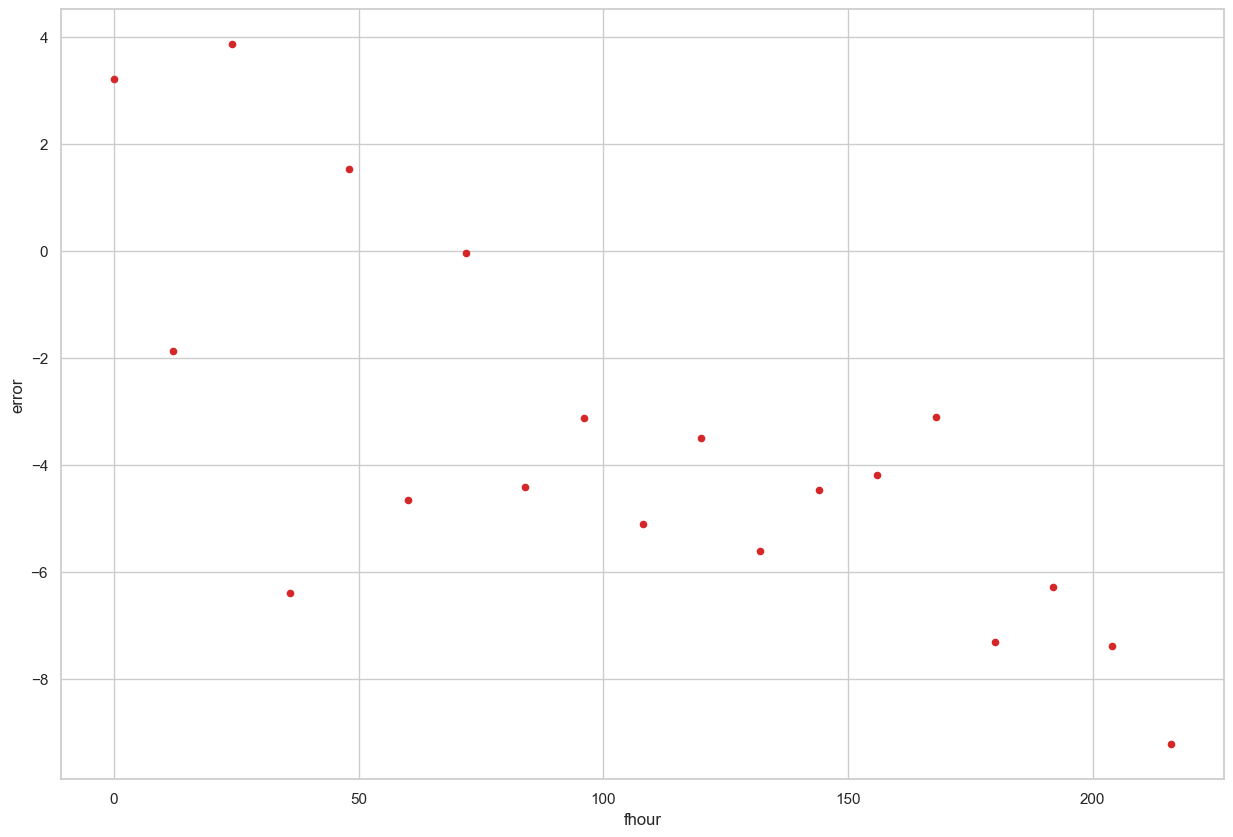

In [67]:
max_heatwave_temps = merged_pangu_ksea_asos_df.loc[heatwave_time_mask].groupby('init_time').max()
min_heatwave_temps = merged_pangu_ksea_asos_df.loc[heatwave_time_mask].groupby('init_time').min()
mean_heatwave_temps = merged_pangu_ksea_asos_df.loc[heatwave_time_mask].groupby('init_time').mean()

max_heatwave_temps['error'] = max_heatwave_temps['pangu_t2c'] - max_heatwave_temps['tmpc']
min_heatwave_temps['error'] = min_heatwave_temps['pangu_t2c'] - min_heatwave_temps['tmpc']
mean_heatwave_temps['error'] = mean_heatwave_temps['pangu_t2c'] - mean_heatwave_temps['tmpc']

fig, ax = plt.subplots(figsize=(15,10))
max_heatwave_temps.plot(ax=ax,x='fhour',y='error',kind='scatter',c='tab:red')
# min_heatwave_temps.plot(ax=ax,x='fhour',y='error',kind='scatter',c='tab:blue')
# mean_heatwave_temps.plot(ax=ax,x='fhour',y='error',kind='scatter',c='tab:green')


In [39]:
merged_pangu_ksea_asos_df.set_index('time')

,latitude,longitude,t2,fhour,init_time,valid,lon,lat,tmpc,pangu_t2c,error
time,,,,,,,,,,,
2021-06-21 00:00:00,47.5,237.75,300.276581,0,2021-06-21 00:00:00,2021-06-21 00:00:00,-122.3144,47.4447,27.220000,27.126587,-0.093413
2021-06-21 06:00:00,47.5,237.75,293.155029,6,2021-06-21 00:00:00,2021-06-21 06:00:00,-122.3144,47.4447,20.560000,20.005035,-0.554965
2021-06-21 12:00:00,47.5,237.75,289.551270,12,2021-06-21 00:00:00,2021-06-21 12:00:00,-122.3144,47.4447,18.330000,16.401276,-1.928724
2021-06-21 18:00:00,47.5,237.75,297.515198,18,2021-06-21 00:00:00,2021-06-21 18:00:00,-122.3144,47.4447,26.110000,24.365204,-1.744796
2021-06-22 00:00:00,47.5,237.75,302.009308,24,2021-06-21 00:00:00,2021-06-22 00:00:00,-122.3144,47.4447,31.110000,28.859314,-2.250686
...,...,...,...,...,...,...,...,...,...,...,...
2021-07-12 12:00:00,47.5,237.75,291.291534,216,2021-07-03 12:00:00,2021-07-12 12:00:00,-122.3144,47.4447,12.780000,18.141541,5.361541
2021-07-12 18:00:00,47.5,237.75,300.015137,222,2021-07-03 12:00:00,2021-07-12 18:00:00,-122.3144,47.4447,21.670000,26.865143,5.195143
2021-07-13 00:00:00,47.5,237.75,303.311035,228,2021-07-03 12:00:00,2021-07-13 00:00:00,-122.3144,47.4447,26.670000,30.161041,3.491041


In [ ]:
merged_pangu_ksea_asos_df['fhour']=merged_pangu_ksea_asos_df['fhour'].astype(int)

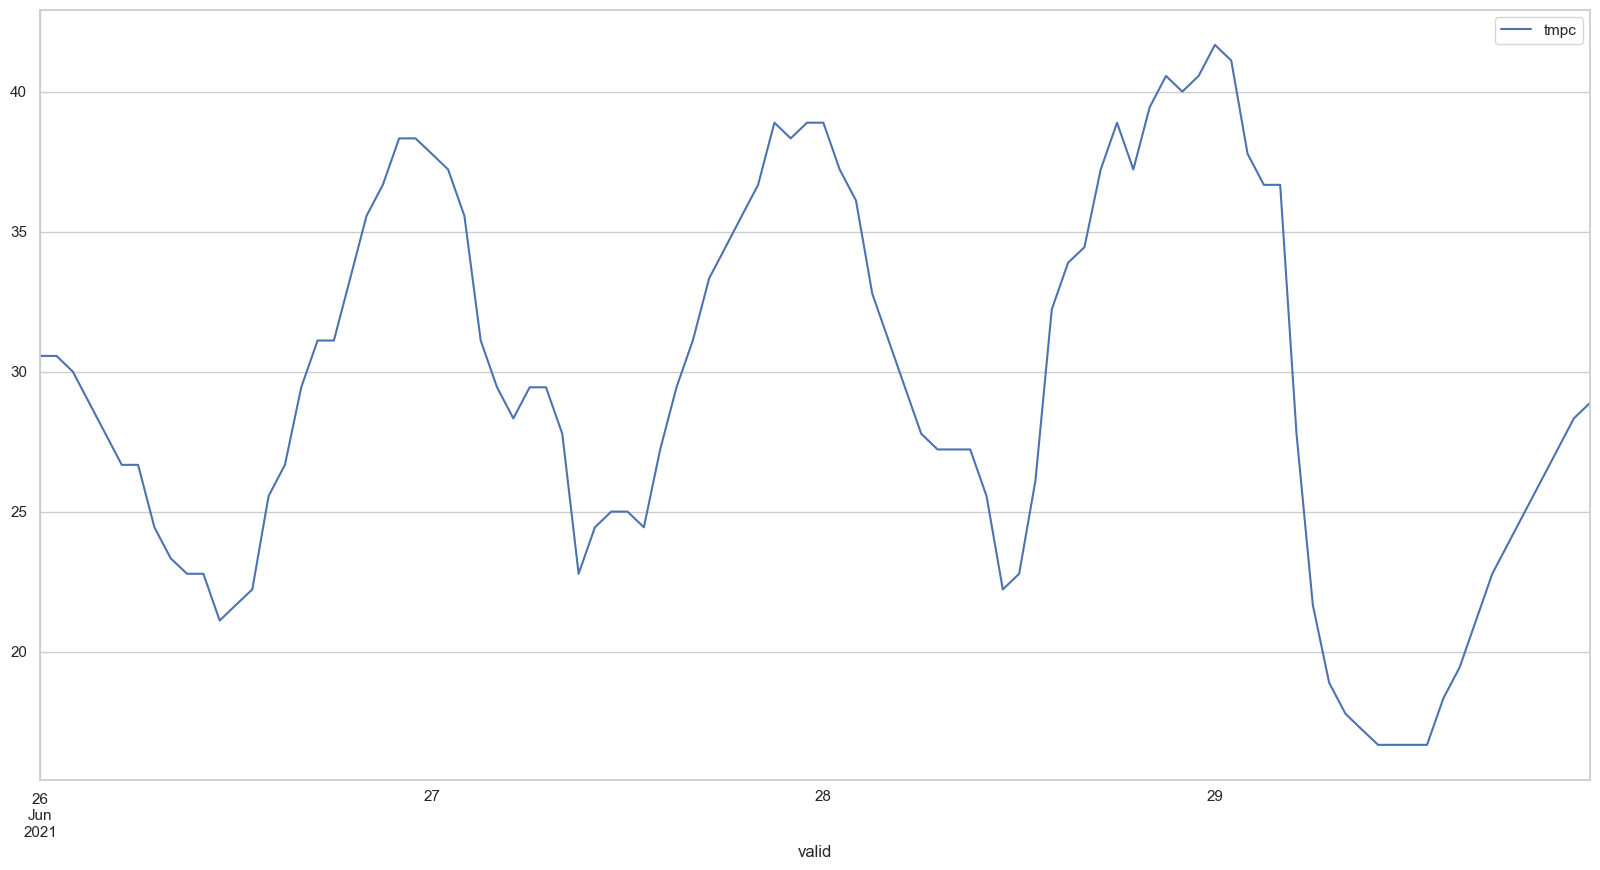

In [ ]:
ksea_df_time_shifted['2021-06-26':'2021-06-29'].plot(y='tmpc',figsize=(20,10))
heatwave_time_mask = (merged_pangu_ksea_asos_df['time']>'2021-06-26') & (merged_pangu_ksea_asos_df['time']< '2021-06-30')

Text(0.0, 1.0, 'Pangu 2m Temperature Errors, KSEA 2021 Jun 26 00z - Jun 30 00z')

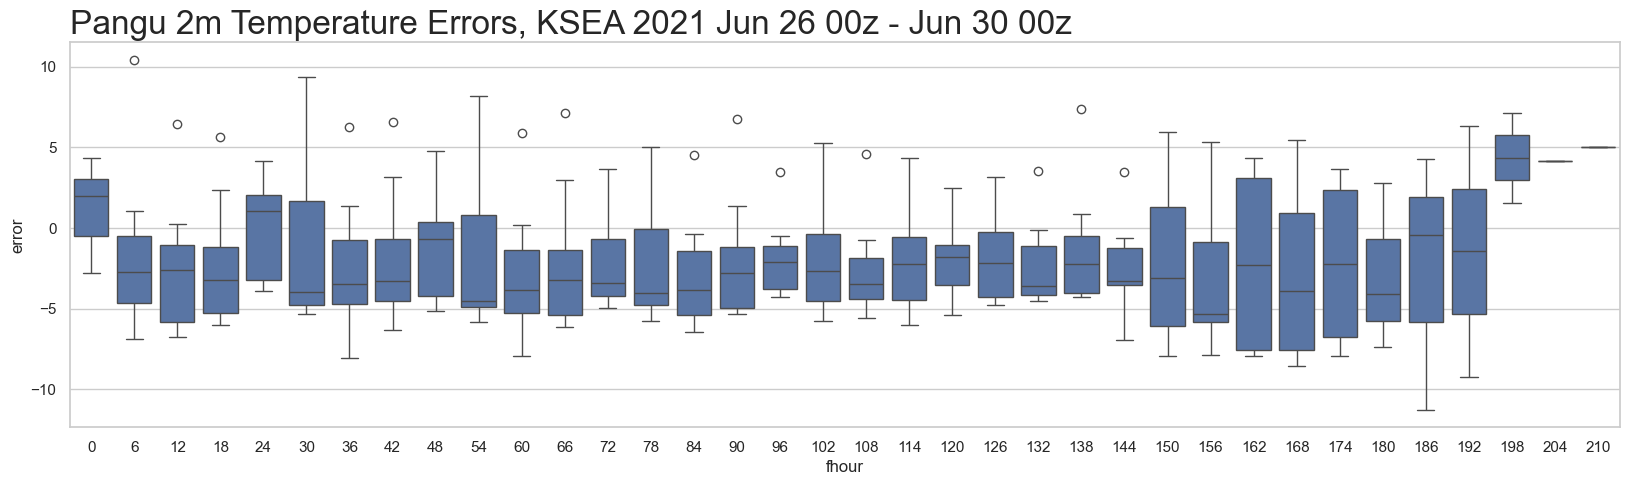

In [ ]:
fig, ax = plt.subplots(1,3,figsize=(20,5))
sns.set_theme(style='whitegrid')

sns.boxplot(ax=ax[0],data=merged_pangu_ksea_asos_df.loc[heatwave_time_mask],x='fhour',y='error')
ax.set_title('Pangu 2m Temperature Errors, KSEA 2021 Jun 26 00z - Jun 30 00z',loc='left',fontsize=24)

sns.boxplot(ax=ax[0],data=merged_pangu_ksea_asos_df.loc[heatwave_time_mask],x='fhour',y='error')
ax.set_title('Pangu 2m Temperature Errors, KSEA 2021 Jun 26 00z - Jun 30 00z',loc='left',fontsize=24)

In [ ]:
heatwave_time_mask = (merged_pangu_ksea_asos_df['time']>'2021-06-26') & (merged_pangu_ksea_asos_df['time']< '2021-06-30')
merged_pangu_ksea_asos_df.loc[heatwave_time_mask]

,time,latitude,longitude,t2,fhour,valid,lon,lat,tmpc,pangu_t2c,error
21,2021-06-26 06:00:00,47.5,237.75,295.474426,126,2021-06-26 06:00:00,-122.3144,47.4447,26.67,22.324432,-4.345568
22,2021-06-26 12:00:00,47.5,237.75,292.711121,132,2021-06-26 12:00:00,-122.3144,47.4447,21.67,19.561127,-2.108873
23,2021-06-26 18:00:00,47.5,237.75,300.035797,138,2021-06-26 18:00:00,-122.3144,47.4447,31.11,26.885803,-4.224197
24,2021-06-27 00:00:00,47.5,237.75,303.994537,144,2021-06-27 00:00:00,-122.3144,47.4447,37.78,30.844543,-6.935457
25,2021-06-27 06:00:00,47.5,237.75,295.968689,150,2021-06-27 06:00:00,-122.3144,47.4447,29.44,22.818695,-6.621305
...,...,...,...,...,...,...,...,...,...,...,...
657,2021-06-29 06:00:00,47.5,237.75,305.251404,6,2021-06-29 06:00:00,-122.3144,47.4447,21.67,32.101410,10.431410
658,2021-06-29 12:00:00,47.5,237.75,296.257935,12,2021-06-29 12:00:00,-122.3144,47.4447,16.67,23.107941,6.437941
659,2021-06-29 18:00:00,47.5,237.75,299.402557,18,2021-06-29 18:00:00,-122.3144,47.4447,23.89,26.252563,2.362563
697,2021-06-29 12:00:00,47.5,237.75,292.074493,0,2021-06-29 12:00:00,-122.3144,47.4447,16.67,18.924500,2.254500


C:\Users\tman1_000\AppData\Local\Temp\ipykernel_624\1780296346.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_pangu_ksea_asos_df.groupby('fhour').apply(lambda x: scores.continuous.mse(x.pangu_t2c,x.tmpc)).plot(ax=ax)
C:\Users\tman1_000\AppData\Local\Temp\ipykernel_624\1780296346.py:3: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  merged_pangu_ksea_asos_df[merged_pangu_ksea_asos_df['tmpc']>np.per

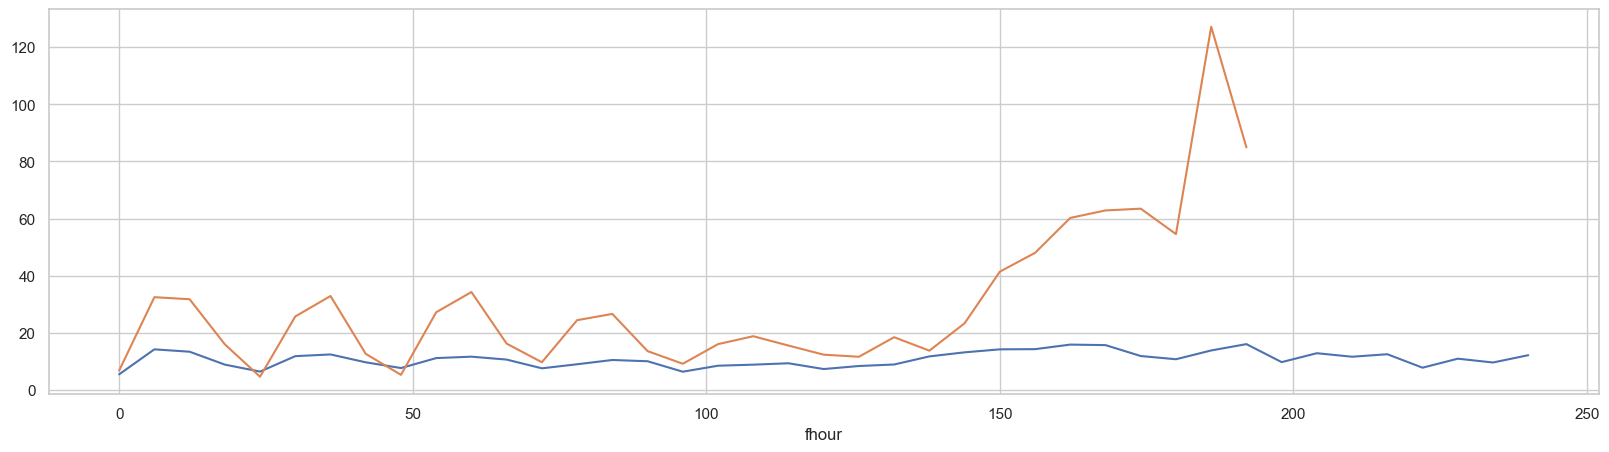

In [ ]:
fig, ax = plt.subplots(figsize=(20,5))
merged_pangu_ksea_asos_df.groupby('fhour').apply(lambda x: scores.continuous.mse(x.pangu_t2c,x.tmpc)).plot(ax=ax)
merged_pangu_ksea_asos_df[merged_pangu_ksea_asos_df['tmpc']>np.percentile(merged_pangu_ksea_asos_df['tmpc'],90)].groupby('fhour').apply(lambda x: scores.continuous.mse(x.pangu_t2c,x.tmpc)).plot(ax=ax)
plt.show()

In [ ]:
fs_ = fsspec.filesystem("reference", fo=json_list[0], ref_storage_args={'skip_instance_cache':True},
                       remote_protocol='gcs', remote_options={'anon':True})
m = fs_.get_mapper("")
ds = xr.open_dataset(m, engine="zarr", backend_kwargs={'consolidated':False}, chunks={})
ds['t2c'] = ds['t2']-273.15

In [ ]:
# for single axes plot colorbars, use
# divider = make_axes_locatable(ax)
# ax_cb = divider.new_horizontal(size="5%", pad=0.1, axes_class=plt.Axes)
# fig.add_axes(ax_cb)
# fig.colorbar(output, cax=ax_cb, label='Temperature (C)')

In [ ]:
ds

<xarray.Dataset> Size: 12GB
Dimensions:    (latitude: 721, level: 13, longitude: 1440, time: 41)
Coordinates:
  * latitude   (latitude) float32 3kB 90.0 89.75 89.5 ... -89.5 -89.75 -90.0
  * level      (level) int32 52B 1000 925 850 700 600 500 ... 250 200 150 100 50
  * longitude  (longitude) float32 6kB 0.0 0.25 0.5 0.75 ... 359.2 359.5 359.8
  * time       (time) datetime64[ns] 328B 2021-06-21 ... 2021-07-01
Data variables:
    msl        (time, latitude, longitude) float32 170MB dask.array<chunksize=(14, 241, 480), meta=np.ndarray>
    q          (time, level, latitude, longitude) float32 2GB dask.array<chunksize=(11, 3, 181, 360), meta=np.ndarray>
    t          (time, level, latitude, longitude) float32 2GB dask.array<chunksize=(11, 3, 181, 360), meta=np.ndarray>
    t2         (time, latitude, longitude) float32 170MB dask.array<chunksize=(14, 241, 480), meta=np.ndarray>
    u          (time, level, latitude, longitude) float32 2GB dask.array<chunksize=(11, 3, 181, 360), meta=np.ndarray>
    u10        (time, latitude, longitude) float32 170MB dask.array<chunksize=(14, 241, 480), meta=np.ndarray>
    v          (time, level, latitude, longitude) float32 2GB dask.array<chunksize=(11, 3, 181, 360), meta=np.ndarray>
    v10        (time, latitude, longitude) float32 170MB dask.array<chunksize=(14, 241, 480), meta=np.ndarray>
    z          (time, level, latitude, longitude) float32 2GB dask.array<chunksize=(11, 3, 181, 360), meta=np.ndarray>
    t2c        (time, latitude, longitude) float32 170MB dask.array<chunksize=(14, 241, 480), meta=np.ndarray>
Attributes:
    Conventions:           CF-1.8
    creation_time:         2023-11-22T05:29:06
    first_forecast_hour:   6
    forecast_hour_step:    6
    initialization_model:  GFS
    initialization_time:   2021-06-21T00:00:00
    last_forecast_hour:    240
    model_name:            Pangu-Weather
    model_version:         v1
    version:               1_2023-10-14

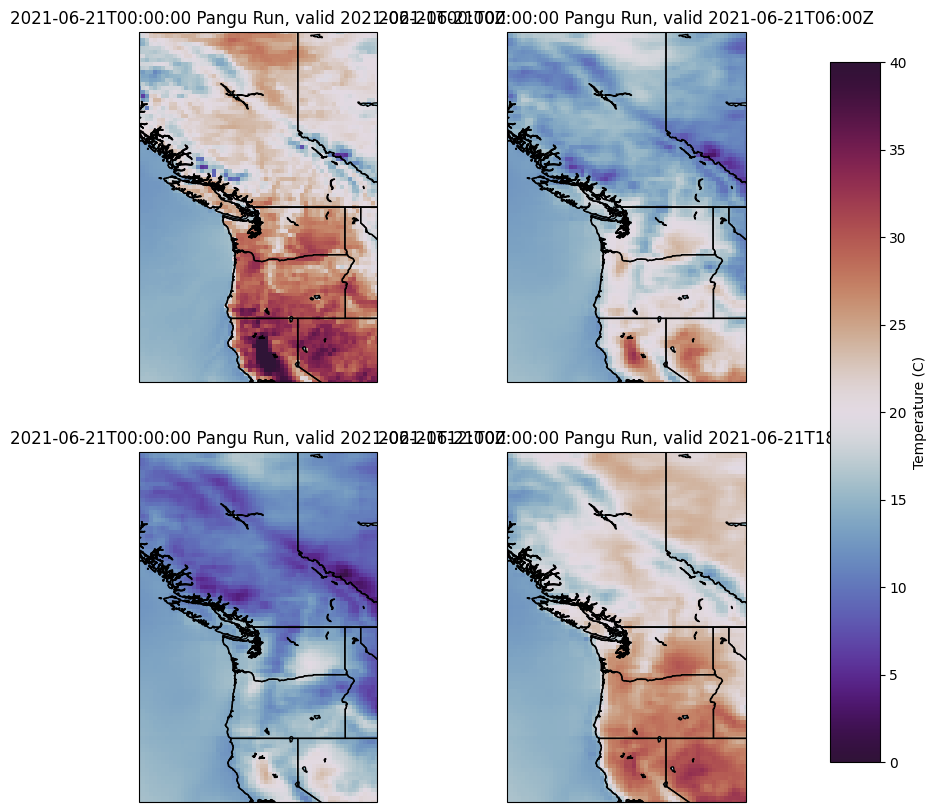

In [ ]:
ds_plot_subset = ds['t2c'].isel(time=slice(0,4))
# Define the extent for the Pacific Northwest
extent = [-130, -115, 38, 60]  # [longitude_min, longitude_max, latitude_min, latitude_max]


# Create the figure and axis with a Cartopy projection
fig, axs = plt.subplots(2,2, figsize=(10, 10), subplot_kw={'projection': ccrs.PlateCarree()})
for i, ax in enumerate(axs.flat):
    ax.set_extent(extent)

    # Add map features
    ax.add_feature(cfeature.BORDERS, linestyle='-', edgecolor='black')
    ax.add_feature(cfeature.LAND, edgecolor='black', facecolor='lightgray')
    ax.add_feature(cfeature.LAKES, edgecolor='black', facecolor='lightblue')
    ax.add_feature(cfeature.COASTLINE, edgecolor='black')
    ax.add_feature(cfeature.STATES,edgecolor='black')

    # Plot the contourf
    output = ds_plot_subset.isel(time=i).plot(ax=ax, cmap='twilight_shifted', vmin=0, vmax=40, transform=ccrs.PlateCarree(),add_colorbar=False)

    # Add a color bar
    ax.set_title(f"{ds.attrs['initialization_time']} Pangu Run, valid {np.datetime_as_string(ds_plot_subset.isel(time=i).time.values,timezone='UTC',unit='m')}")

# divider = make_axes_locatable(ax)
# cax = divider.append_axes('right', size='5%', pad=0.05)
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(output, cax=cbar_ax,cmap = 'twilight_shifted', label = "Temperature (C)")
# fig.colorbar(output, shrink = 1,ax=axs, orientation='horizontal')
plt.show()

# Load ERA5 and Compare

In [ ]:
era5 = xr.open_zarr(
    "gs://gcp-public-data-arco-era5/ar/1959-2022-full_37-1h-0p25deg-chunk-1.zarr-v2",
    chunks={'time': 48},
    consolidated=True,
)
era5

x:\anaconda3\envs\brightband\Lib\site-packages\google\auth\_default.py:76: UserWarning: Your application has authenticated using end user credentials from Google Cloud SDK without a quota project. You might receive a "quota exceeded" or "API not enabled" error. See the following page for troubleshooting: https://cloud.google.com/docs/authentication/adc-troubleshooting/user-creds. 
  warnings.warn(_CLOUD_SDK_CREDENTIALS_WARNING)


<xarray.Dataset> Size: 534TB
Dimensions:                                           (time: 552264,
                                                       latitude: 721,
                                                       longitude: 1440,
                                                       level: 37)
Coordinates:
  * latitude                                          (latitude) float32 3kB ...
  * level                                             (level) int64 296B 1 .....
  * longitude                                         (longitude) float32 6kB ...
  * time                                              (time) datetime64[ns] 4MB ...
Data variables: (12/31)
    10m_u_component_of_wind                           (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    10m_v_component_of_wind                           (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    2m_temperature                                    (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    angle_of_sub_gridscale_orography                  (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    anisotropy_of_sub_gridscale_orography             (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    geopotential                                      (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    ...                                                ...
    total_precipitation                               (time, latitude, longitude) float32 2TB dask.array<chunksize=(48, 721, 1440), meta=np.ndarray>
    type_of_high_vegetation                           (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    type_of_low_vegetation                            (latitude, longitude) float32 4MB dask.array<chunksize=(721, 1440), meta=np.ndarray>
    u_component_of_wind                               (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    v_component_of_wind                               (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>
    vertical_velocity                                 (time, level, latitude, longitude) float32 85TB dask.array<chunksize=(48, 37, 721, 1440), meta=np.ndarray>